In [1]:
! hostname
! whoami
! pwd
# ! nvidia-smi

31-34-203.wireless.csail.mit.edu
akarshkumar0101
/Users/akarshkumar0101/exploration-generalization


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from functools import partial
from einops import rearrange, repeat
import gymnasium as gym
# import gym as gym_old
import gym
from tqdm.auto import tqdm
import cv2
import os
import re
# from ppo import *

import procgen
from procgen import ProcgenEnv

from IPython.display import clear_output

import env_utils
import models
import ppo_rnd
import train
import pretrain
import bc
from pretrain import get_level2files

In [4]:
from env_procgen import make_env
from agent_procgen import E3B

# Collecting Data

In [69]:
device = 'cpu'
env = make_env('miner', 'ext', 64, 0, 0, 'hard', 0.999, e3b=None, device=device)
action_list = np.array([4, 1, 3, 5, 7])
obs, info = env.reset()
obss, actions = [obs], []
for i in tqdm(range(10000)):
    action = np.random.randint(low=0, high=len(action_list), size=env.num_envs)
    obs, rew, done, info = env.step(action_list[action])
    obss.append(obs)
    actions.append(action)
obss = np.stack(obss)
actions = np.stack(actions)

  0%|          | 0/10000 [00:00<?, ?it/s]

right


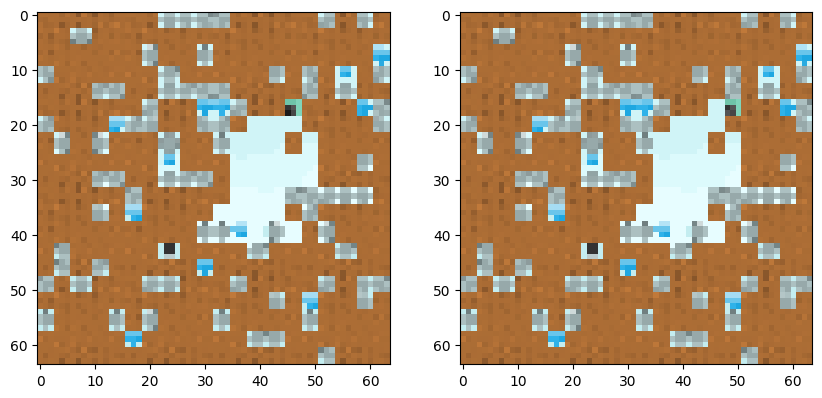

right


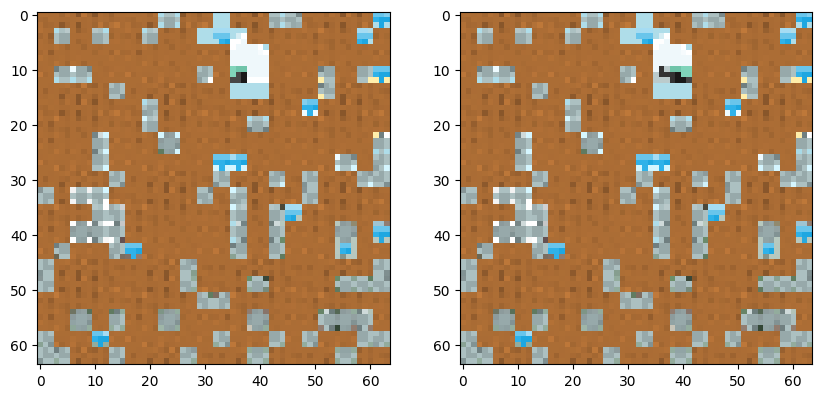

left


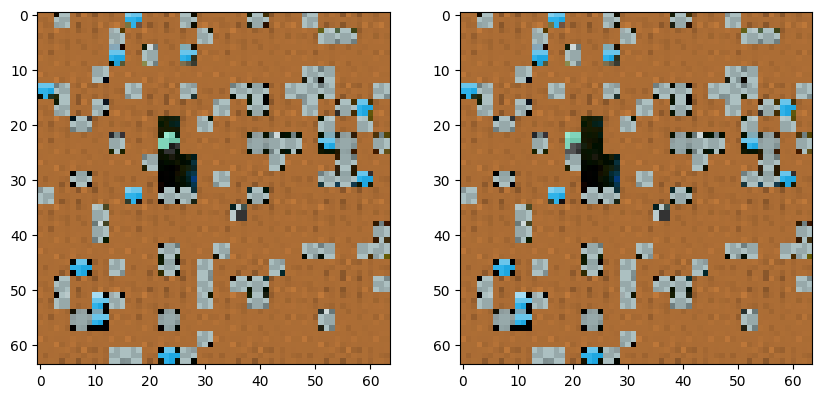

up


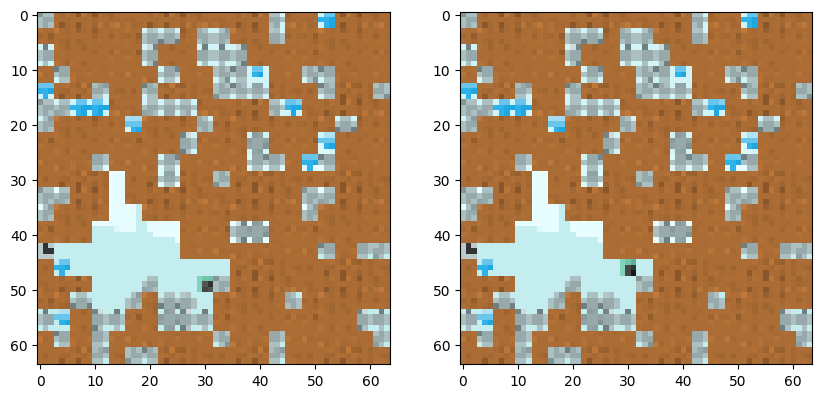

nothing


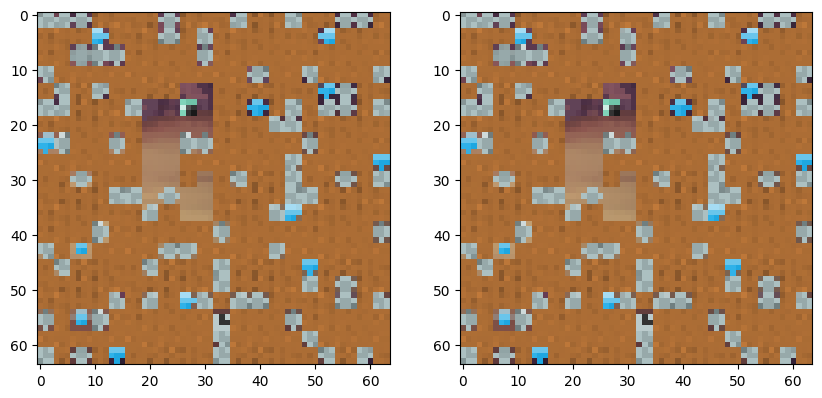

left


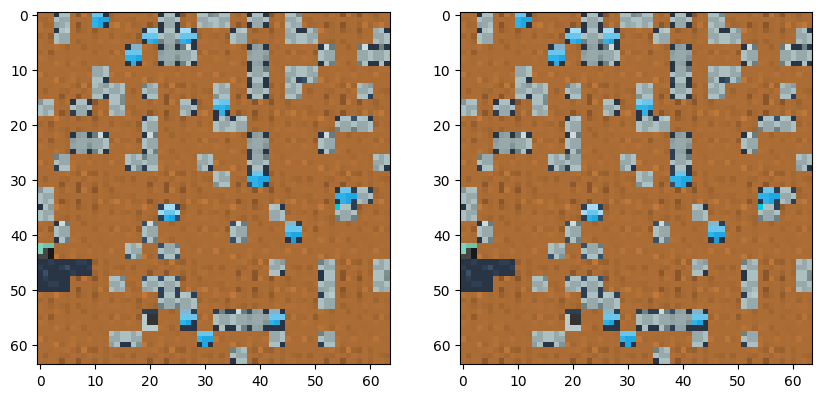

nothing


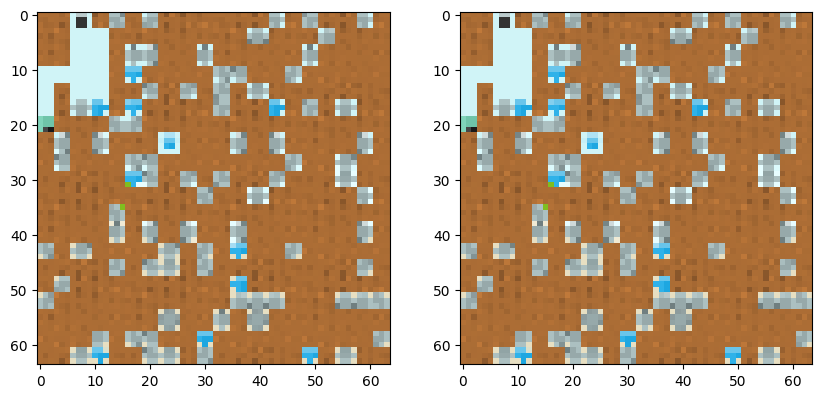

left


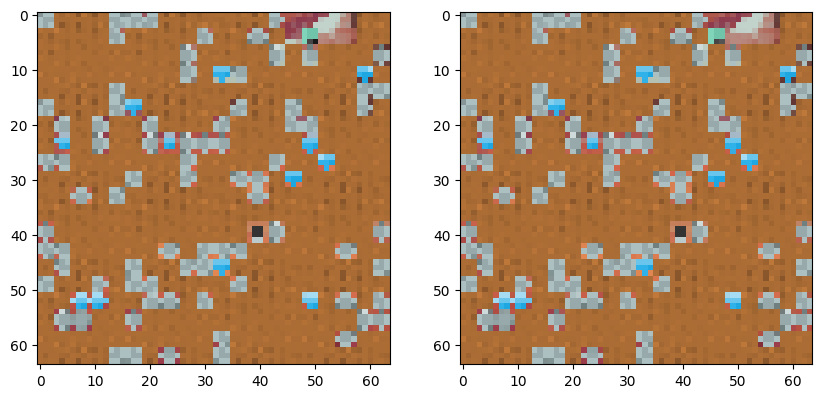

right


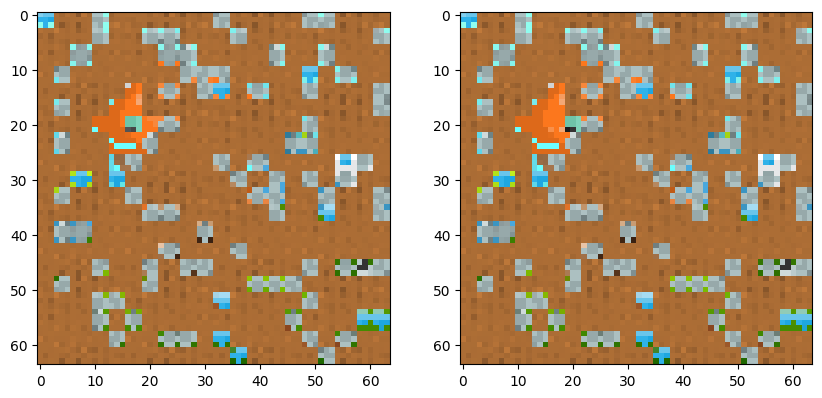

nothing


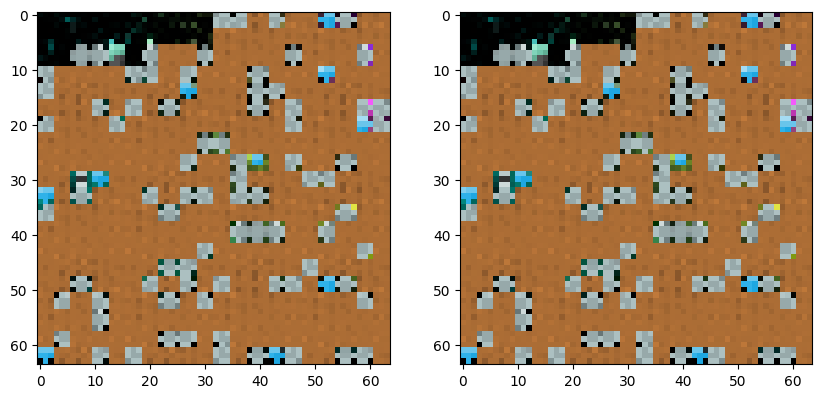

In [70]:
device, batch_size = 'cpu', 10

i_step = torch.randint(low=0, high=len(obss)-1, size=(batch_size, ))
i_env = torch.randint(low=0, high=env.num_envs, size=(batch_size, ))

obs_now = torch.from_numpy(obss[i_step, i_env]).to(device)
obs_nxt = torch.from_numpy(obss[i_step+1, i_env]).to(device)
action_now = torch.from_numpy(actions[i_step, i_env]).to(device)

for i in range(10):
    print(['nothing', 'left', 'down', 'up', 'right'][action_now[i].item()])
    plt.figure(figsize=(10, 5))
    plt.subplot(121); plt.imshow(obs_now[i].cpu().numpy())
    plt.subplot(122); plt.imshow(obs_nxt[i].cpu().numpy())
    plt.show()

In [ ]:
obss[0,0].shape

(64, 64, 3)

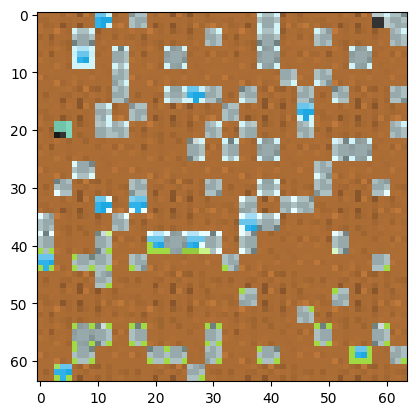

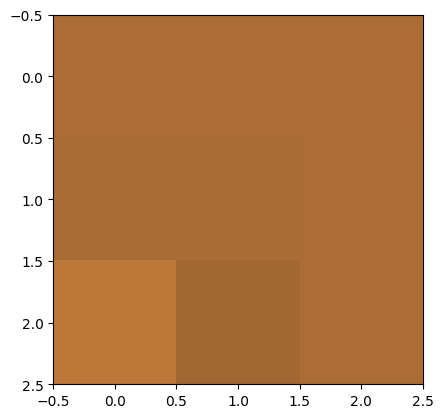

In [8]:
plt.imshow(obss[0,0])
plt.show()
plt.imshow(obss[0,0, 58:61, 35:38])
plt.show()

In [349]:
device = 'mps'
batch_size = 256
e3b = E3B(64, obs_shape=(64, 64, 3), n_actions=5, n_features=100, lmbda=0.1)
e3b.to(device)
opt = torch.optim.Adam(e3b.idm.parameters(), lr=5e-4)#, weight_decay=1e-5)

losses = []

i_step = torch.randint(low=0, high=len(obss)-1, size=(batch_size, ))
i_env = torch.randint(low=0, high=env.num_envs, size=(batch_size, ))
pbar = tqdm(range(1000))
for i_batch in pbar:
    obs_now = obss[i_step, i_env]
    obs_nxt = obss[i_step+1, i_env]
    action_now = actions[i_step, i_env]
    obs_now, obs_nxt = torch.from_numpy(obs_now).to(device), torch.from_numpy(obs_nxt).to(device)
    action_now = torch.from_numpy(action_now).to(device)
    logits = e3b.idm(obs_now, obs_nxt)
    
    with torch.no_grad():
        v1 = e3b.idm.calc_features(obs_now)
        v2 = e3b.idm.calc_features(obs_nxt)
        vlen = (v1-v2).norm(dim=-1).mean()
    
    # if i_batch<20:
    #     loss = (vlen-1.).abs()
    # else:
    ce = torch.nn.functional.cross_entropy(logits, action_now, reduction='none')
    loss = ce.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    pbar.set_postfix(loss=str(loss.item()), vlen=str(vlen.item()))
    losses.append(loss.item())
    # print(torch.tensor([p.std().item() for p in e3b.idm.parameters()]).mean().item())
    # print(e3b.idm.network[0].conv.weight[0,0,0,0].item())
    # print(e3b.idm.network[0].conv.weight.grad[0,0,0,0].item())
    # print()
    

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

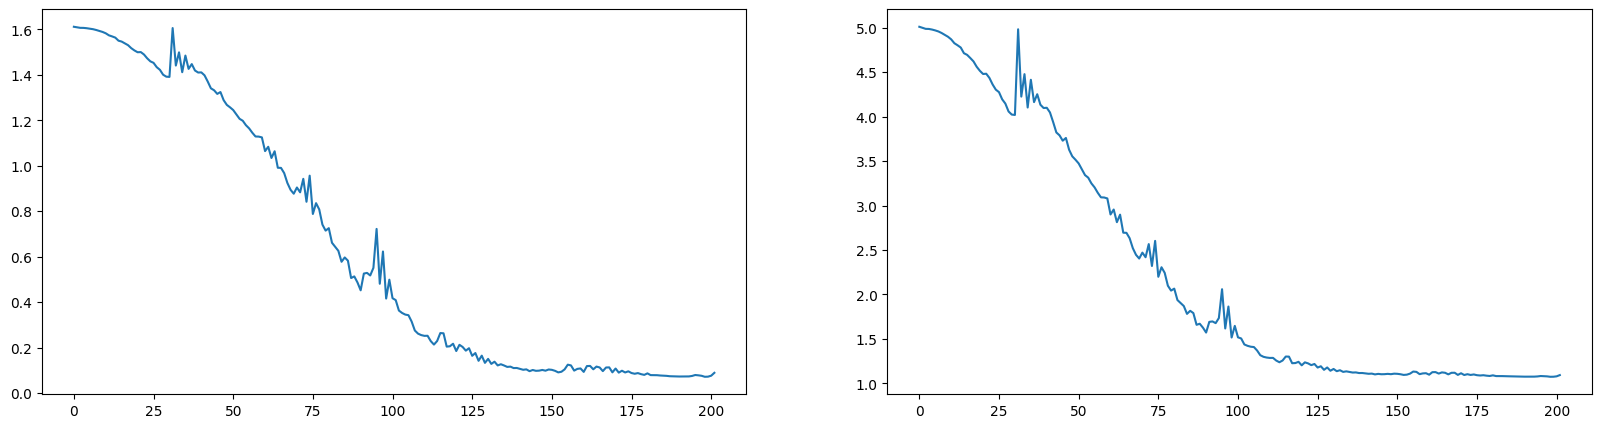

In [277]:
plt.figure(figsize=(20, 5))
plt.subplot(121); plt.plot(np.array(losses))
plt.subplot(122); plt.plot(np.e**np.array(losses))

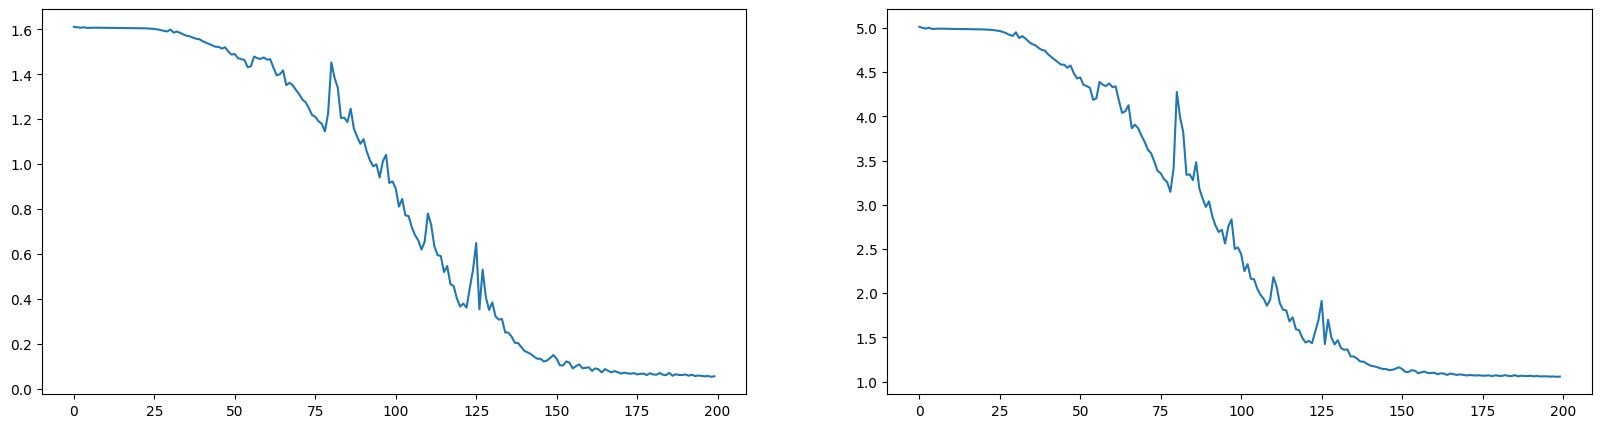

In [267]:
plt.figure(figsize=(20, 5))
plt.subplot(121); plt.plot(np.array(losses))
plt.subplot(122); plt.plot(np.e**np.array(losses))

Action:  0


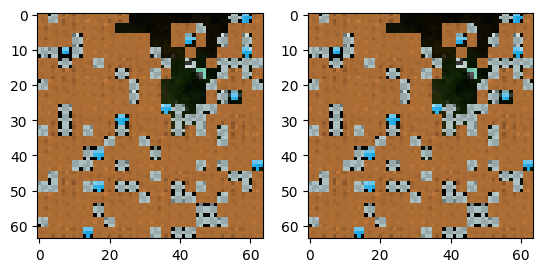

In [233]:
i = 7
plt.subplot(121)
plt.imshow(obs_now[i].cpu().numpy())
plt.subplot(122)
plt.imshow(obs_nxt[i].cpu().numpy())
print('Action: ', action_now[i].item())

(array([43.,  0., 59.,  0.,  0., 40.,  0., 59.,  0., 55.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

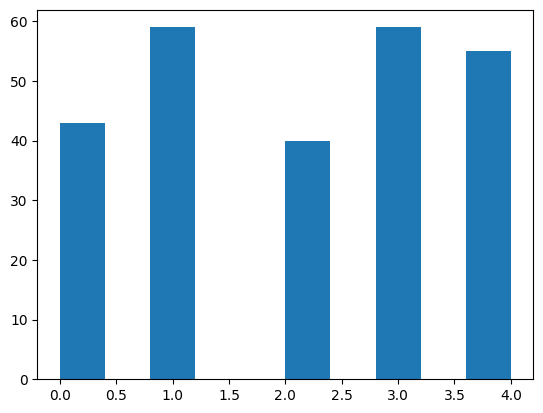

In [ ]:
plt.hist(action_now.cpu().numpy())

In [297]:
from agent_procgen import Agent

In [344]:
device = 'mps'
batch_size = 256

agent = Agent((64, 64, 6), 5)
agent = agent.to(device)
opt = torch.optim.Adam(agent.parameters(), lr=1e-4)#, weight_decay=1e-5)

losses = []

pbar = tqdm(range(10000))
for i_batch in pbar:
    i_step = torch.randint(low=0, high=len(obss)-1, size=(batch_size, ))
    i_env = torch.randint(low=0, high=env.num_envs, size=(batch_size, ))
    obs_now = obss[i_step, i_env]
    obs_nxt = obss[i_step+1, i_env]
    action_now = actions[i_step, i_env]
    obs_now, obs_nxt = torch.from_numpy(obs_now).to(device), torch.from_numpy(obs_nxt).to(device)
    action_now = torch.from_numpy(action_now).to(device)
    _, _, _, _, logits = agent.get_action_and_value(torch.cat([obs_now, obs_nxt], dim=-1), action=action_now)
    
    # if i_batch<20:
    #     loss = (vlen-1.).abs()
    # else:
    ce = torch.nn.functional.cross_entropy(logits, action_now, reduction='none')
    loss = ce.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    pbar.set_postfix(loss=str(loss.item()))
    losses.append(loss.item())
    # print(torch.tensor([p.std().item() for p in e3b.idm.parameters()]).mean().item())
    # print(e3b.idm.network[0].conv.weight[0,0,0,0].item())
    # print(e3b.idm.network[0].conv.weight.grad[0,0,0,0].item())
    # print()
    

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [345]:
obss.shape

(10001, 64, 64, 64, 3)

In [346]:
10001*64

640064

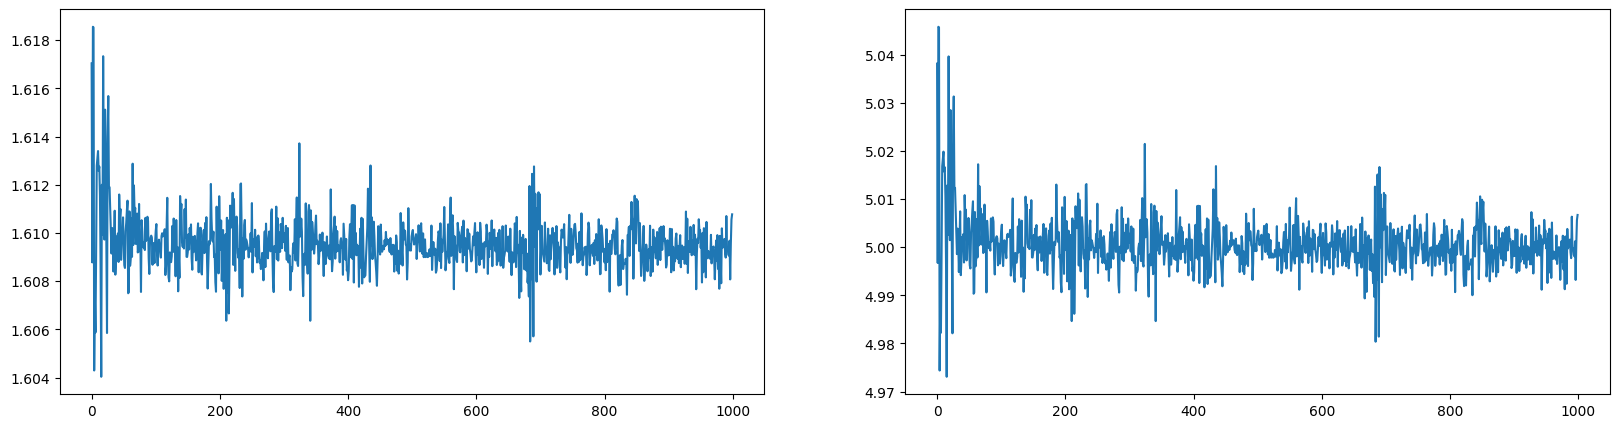

In [337]:
plt.figure(figsize=(20, 5))
plt.subplot(121); plt.plot(np.array(losses))
plt.subplot(122); plt.plot(np.e**np.array(losses))

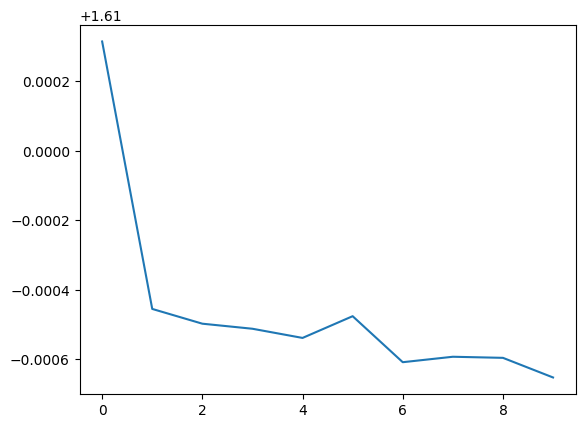

In [343]:
plt.plot(np.array(losses).reshape(10, 100).mean(axis=-1))

In [352]:
np.sum([p.numel() for p in e3b.idm.parameters()])

303505

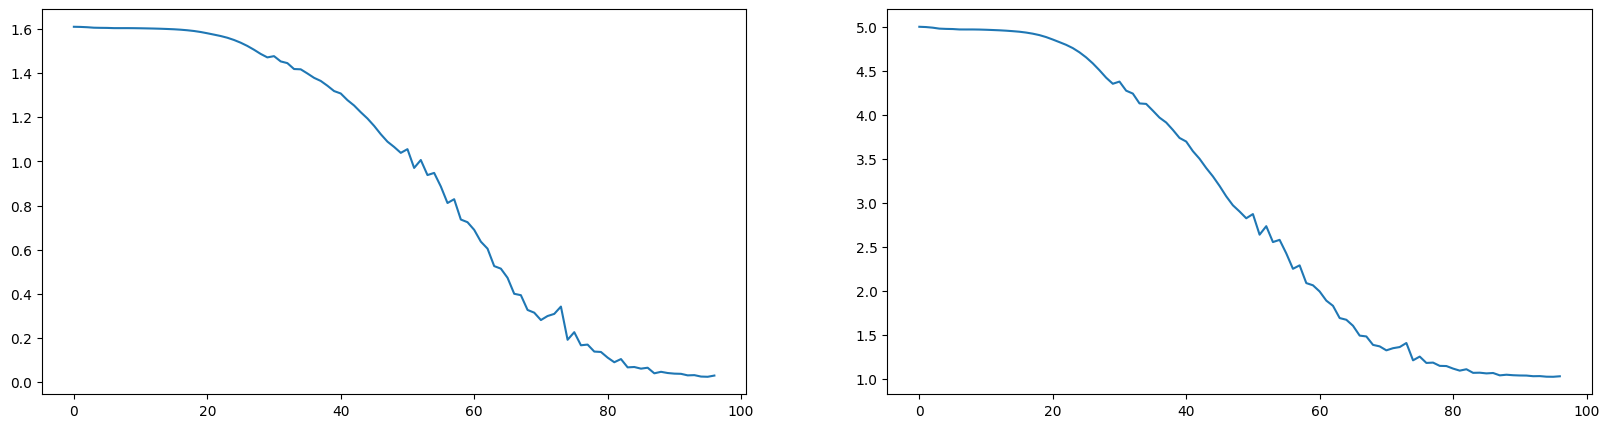

In [308]:
plt.figure(figsize=(20, 5))
plt.subplot(121); plt.plot(np.array(losses))
plt.subplot(122); plt.plot(np.e**np.array(losses))

In [313]:
obs_now.shape, obs_nxt.shape, action_now.shape

(torch.Size([1024, 64, 64, 3]),
 torch.Size([1024, 64, 64, 3]),
 torch.Size([1024]))

right


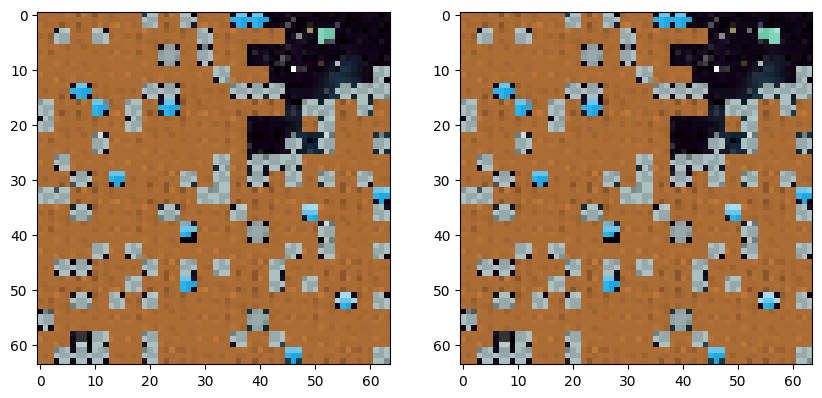

left


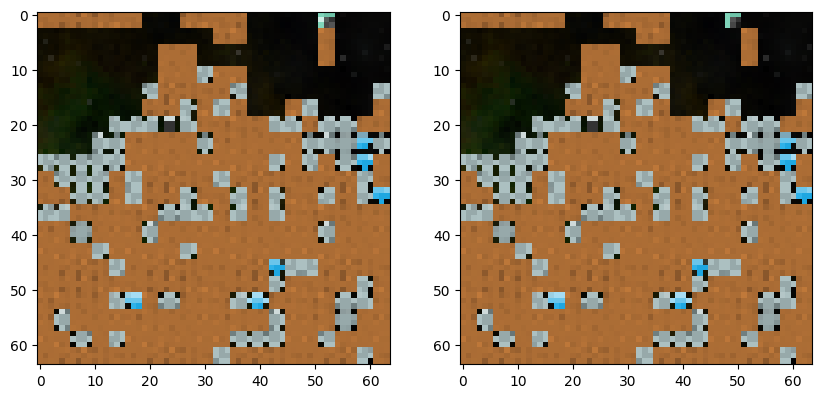

left


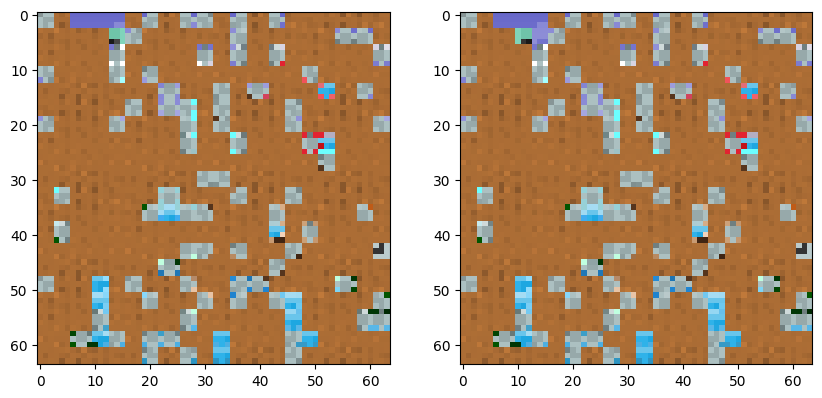

down


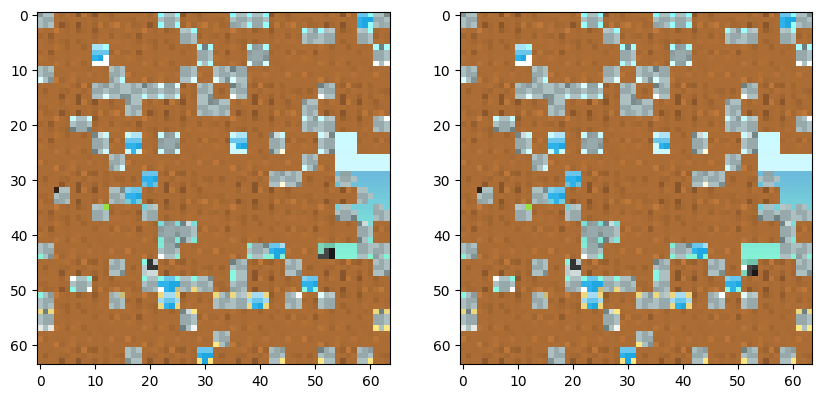

right


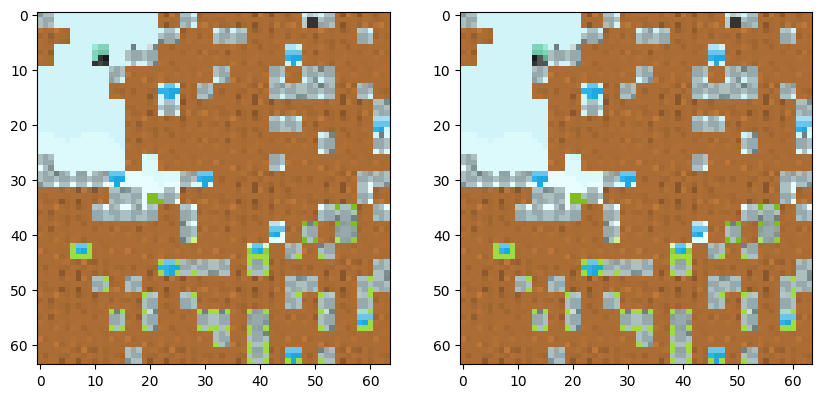

left


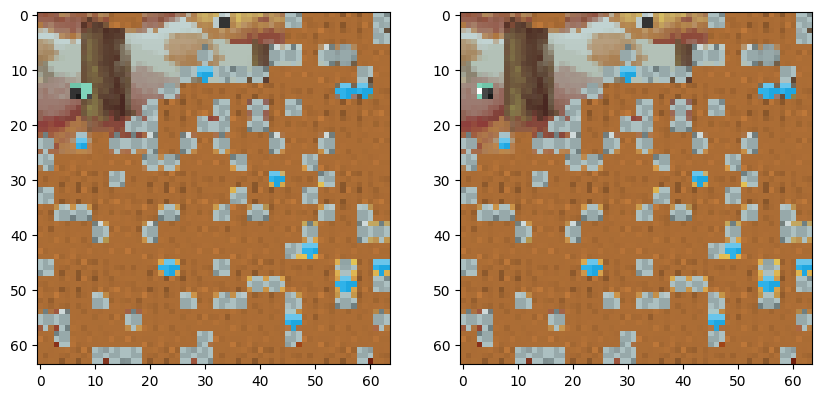

down


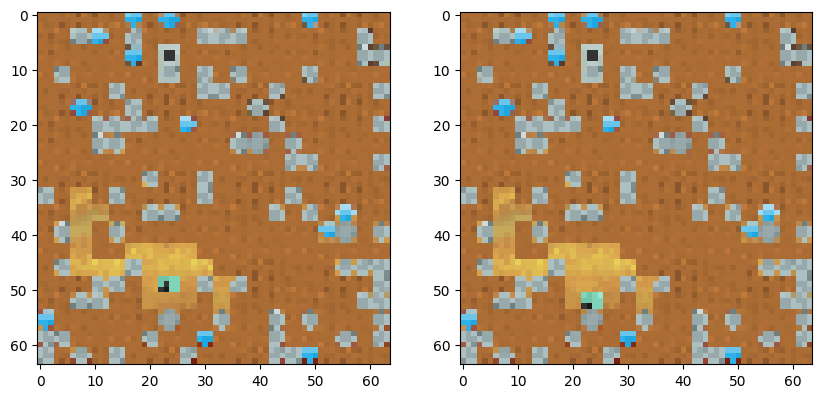

right


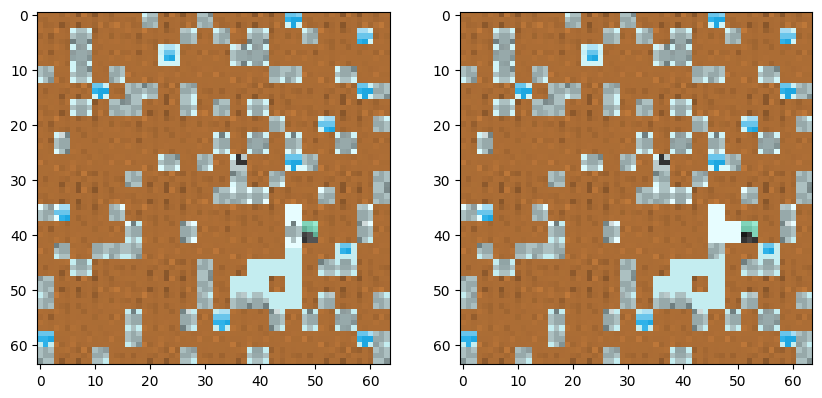

nothing


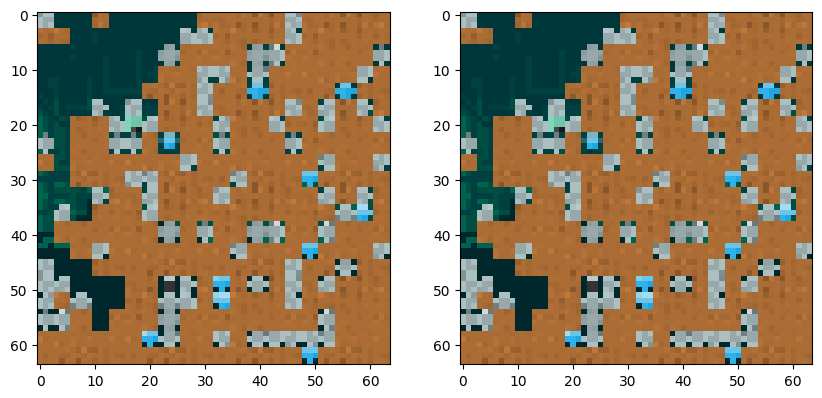

up


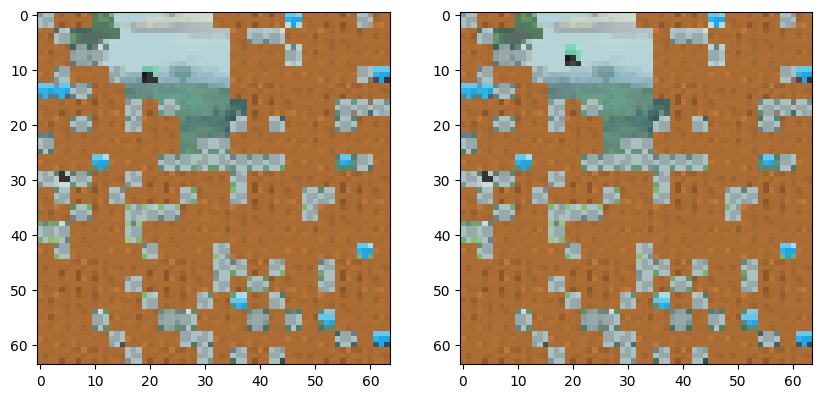

In [11]:
obss.shape

(10001, 64, 64, 64, 3)

In [71]:
from agent_procgen import ResidualBlock
class Net(nn.Module):
    def __init__(self, in_ch=6):
        super().__init__()
        
        self.net = []
        self.conv = nn.Conv2d(in_ch, 64, 3)
        for _ in range(6):
            self.net.append(ResidualBlock(64))
        self.net = nn.Sequential(*self.net)
        self.pool = nn.AdaptiveMaxPool2d([3, 3])
        
        self.net2 = nn.Sequential(
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 5),
        )
        
    def forward(self, x):
        x = x.permute((0, 3, 1, 2)) / 255.0  # "bhwc" -> "bchw"
        x = self.conv(x)
        x = self.net(x)
        x = self.pool(x)
        x = x.flatten(1, -1)
        x = self.net2(x)
        return x

net = Net()

net(torch.randn(8, 64, 64, 6));
np.sum([p.numel() for p in net.parameters()])

521157

In [72]:
device = 'mps'
batch_size = 256

net = Net(in_ch=6)
net = net.to(device)
opt = torch.optim.Adam(net.parameters(), lr=1e-2)#, weight_decay=1e-5)

losses = []

pbar = tqdm(range(10000))
for i_batch in pbar:
    opt.zero_grad()
    
    i_step = torch.randint(low=0, high=len(obss)-1, size=(batch_size, ))
    i_env = torch.randint(low=0, high=env.num_envs, size=(batch_size, ))
    obs_now = torch.from_numpy(obss[i_step, i_env]).to(device)
    obs_nxt = torch.from_numpy(obss[i_step+1, i_env]).to(device)
    action_now = torch.from_numpy(actions[i_step, i_env]).to(device)
    logits = net(torch.cat([obs_now, obs_nxt], dim=-1))
    # logits = net(obs_nxt - obs_now)
    
    ce = torch.nn.functional.cross_entropy(logits, action_now, reduction='none')
    loss = ce.mean()
               
    loss.backward()
    opt.step()
    
    pbar.set_postfix(loss=str(loss.item()))
    losses.append(loss.item())


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

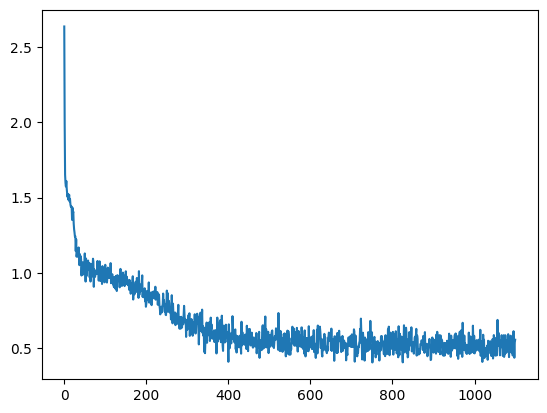

In [49]:
plt.plot(losses)

In [50]:
obss.shape

(10001, 64, 64, 64, 3)

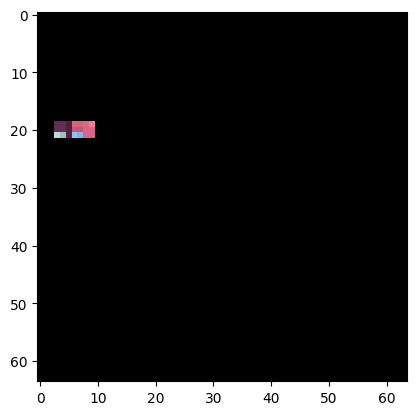

In [57]:
plt.imshow(obss[1, 0]-obss[0, 0])

In [89]:
def multi_batch(ndim):
    def cvt_fn(fn):
        def new_fn(x):
            bs, ds = x.shape[:-ndim], x.shape[-ndim:]
            x = x.reshape(-1, *ds)
            x = fn(x)
            ds = x.shape[1:]
            x = x.reshape(*bs, *ds)
            return x
        return new_fn
    return cvt_fn



In [90]:
net = nn.Conv2d(3, 3, 3, padding=1)
@multi_batch(ndim=3)
def something(x):
    print(x.shape)
    return net(x)

x = torch.randn(2, 2, 3, 10, 10)
something(x).shape

torch.Size([4, 3, 10, 10])


torch.Size([2, 2, 3, 10, 10])